In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("data.csv")
df.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


In [6]:
df.isnull().sum()

Age                    0
Gender                 0
EducationLevel         0
ExperienceYears        0
PreviousCompanies      0
DistanceFromCompany    0
InterviewScore         0
SkillScore             0
PersonalityScore       0
RecruitmentStrategy    0
HiringDecision         0
dtype: int64

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [10]:
X = df.drop("HiringDecision", axis = 1)
y = df["HiringDecision"]


In [18]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [24]:
print(f"Random Forest Classifier Accuracy: {accuracy:.4f}")

Random Forest Classifier Accuracy: 0.9333


In [26]:
pip install shap dice-ml

Note: you may need to restart the kernel to use updated packages.


Features used by rf_classifier: ['Age', 'Gender', 'EducationLevel', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy']
X_test columns: ['Age', 'Gender', 'EducationLevel', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy']
X_test shape: (300, 10)
Type of shap_values: <class 'numpy.ndarray'>
SHAP values shape: (300, 10, 2)
Number of classes: 2
SHAP values shape: (300, 10, 2) (n_samples, n_features, n_classes). Selecting positive class.
Selected SHAP values shape: (300, 10)
Expected shape: (300, 10)
SHAP base value for positive class: 0.3142916666666666

SHAP Explanations for First 5 Instances (Feature Contributions to Class 1):
   Instance  Predicted Class Predicted Probability (Class 1)       Age  \
0         0                0                           0.060 -0.009853   
1         1                0                


SHAP Force Plot for Instance 0 (Predicted Class: 0, Probability: 0.060)


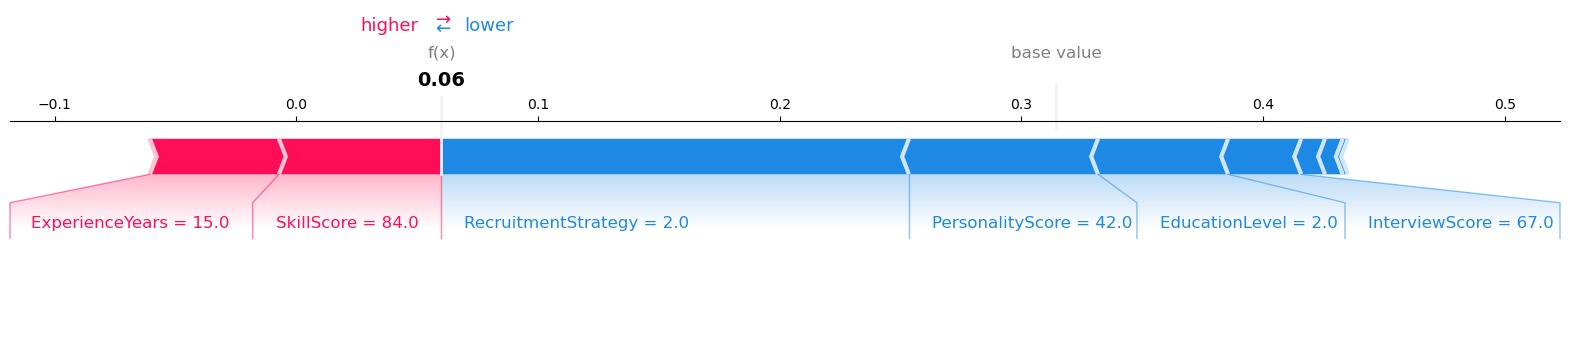


SHAP Force Plot for Instance 1 (Predicted Class: 0, Probability: 0.190)


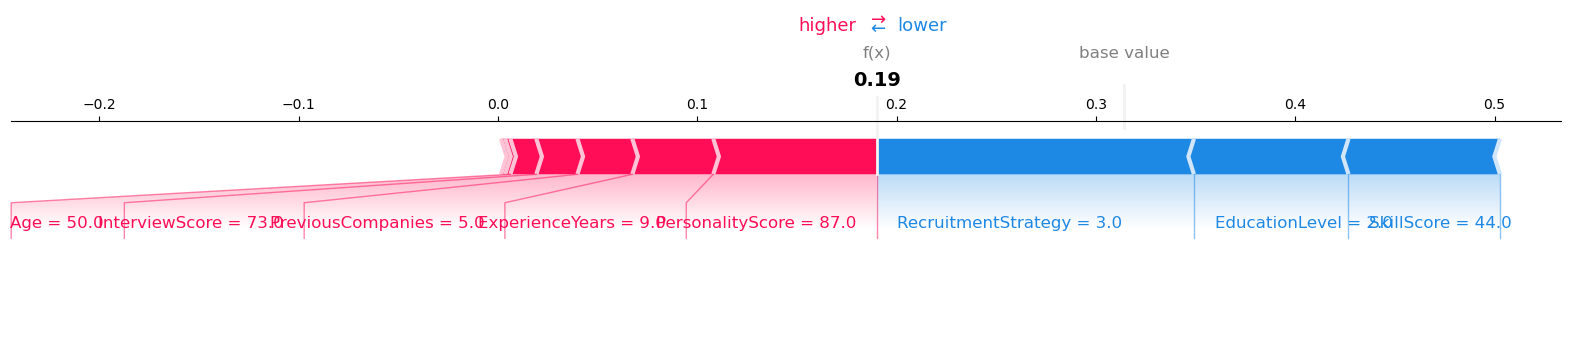


SHAP Force Plot for Instance 2 (Predicted Class: 1, Probability: 0.630)


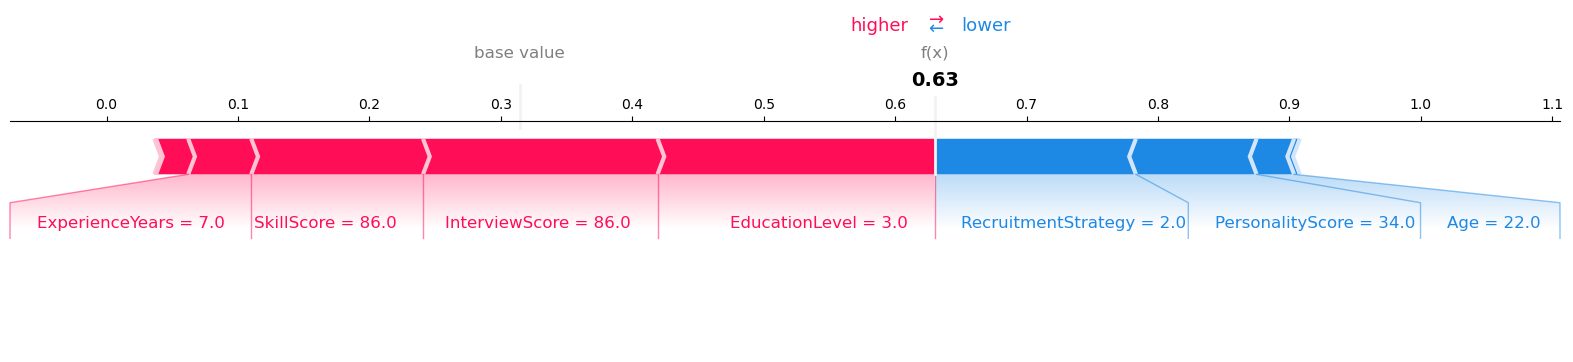


SHAP Force Plot for Instance 3 (Predicted Class: 0, Probability: 0.000)


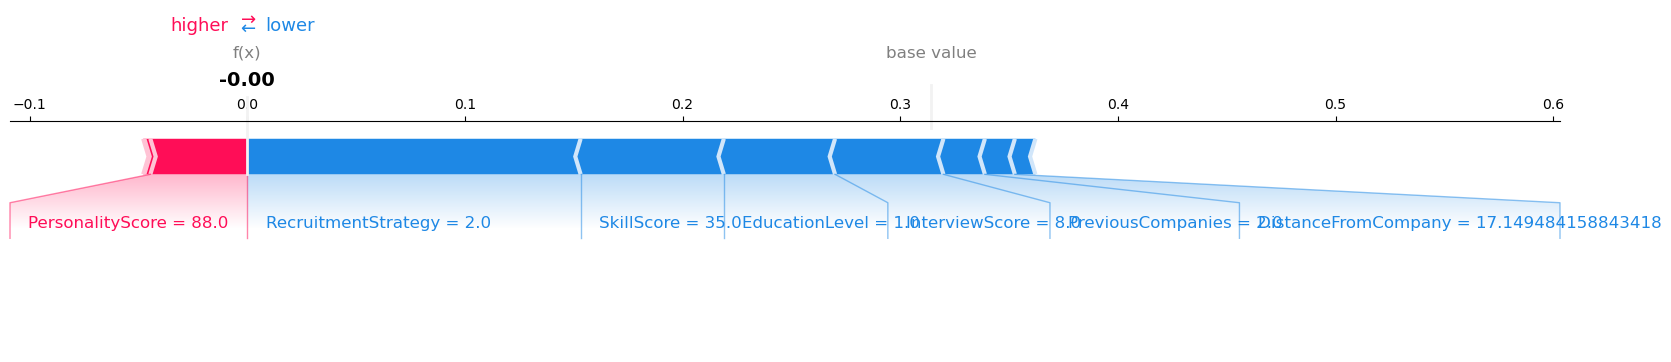


SHAP Force Plot for Instance 4 (Predicted Class: 0, Probability: 0.110)


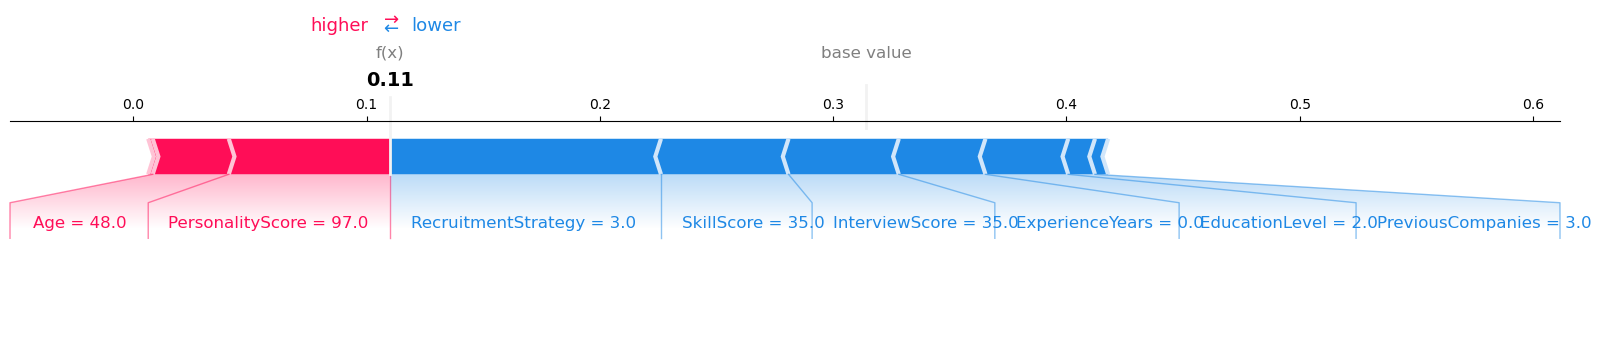


Saved SHAP explanations for all instances to 'shap_explanations_all_instances.csv'.

Top 5 Most Important Features (SHAP):
               feature  shap_importance
9  RecruitmentStrategy         0.222119
2       EducationLevel         0.077163
7           SkillScore         0.074214
8     PersonalityScore         0.072455
6       InterviewScore         0.061072


In [40]:
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Step 1: Verify Features and Data
try:
    model_features = rf_classifier.feature_names_in_
    print("Features used by rf_classifier:", model_features.tolist())
except AttributeError:
    print("Warning: rf_classifier does not have feature_names_in_. Assuming X_train columns.")
    model_features = X_train.columns

print("X_test columns:", X_test.columns.tolist())
print(f"X_test shape: {X_test.shape}")

# Ensure X_test matches model features
missing_features = [f for f in model_features if f not in X_test.columns]
extra_features = [f for f in X_test.columns if f not in model_features]
if missing_features:
    raise ValueError(f"X_test is missing features required by the model: {missing_features}")
if extra_features:
    print(f"Warning: X_test contains extra features not used by the model: {extra_features}")
    X_test = X_test[model_features]

# Step 2: Compute SHAP Values
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test)

# Verify SHAP values structure
print("Type of shap_values:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values is a list with shapes:", [v.shape for v in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# Handle binary classification (2 classes)
n_classes = len(np.unique(y))
print(f"Number of classes: {n_classes}")

if n_classes == 2:
    if isinstance(shap_values, list):
        if len(shap_values) == 2:
            shap_values_array = shap_values[1]  # Positive class (class 1)
        else:
            raise ValueError(f"Unexpected shap_values list length: {len(shap_values)}. Expected 2.")
    else:
        if shap_values.ndim == 3 and shap_values.shape[2] == 2:
            print("SHAP values shape:", shap_values.shape, "(n_samples, n_features, n_classes). Selecting positive class.")
            shap_values_array = shap_values[:, :, 1]  # Positive class
        else:
            raise ValueError(f"Unexpected shap_values shape: {shap_values.shape}. Expected (n_samples, n_features, 2).")
else:
    raise ValueError("This code is designed for binary classification.")

# Verify SHAP values shape
print(f"Selected SHAP values shape: {shap_values_array.shape}")
print(f"Expected shape: ({X_test.shape[0]}, {len(model_features)})")

if shap_values_array.shape != (X_test.shape[0], len(model_features)):
    raise ValueError(f"SHAP values shape {shap_values_array.shape} does not match expected ({X_test.shape[0]}, {len(model_features)}).")

# Step 3: Get Predictions and Base Value
predictions = rf_classifier.predict(X_test)
probabilities = rf_classifier.predict_proba(X_test)[:, 1]  # Probability of positive class
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value
print(f"SHAP base value for positive class: {base_value}")

# Step 4: Generate Explanations for Each Prediction
# Create a DataFrame to store explanations for the first 5 instances
n_display = 5  # Number of instances to display
explanations = []

for i in range(min(n_display, len(X_test))):
    instance = X_test.iloc[i]
    shap_vals = shap_values_array[i]
    pred = predictions[i]
    prob = probabilities[i]
    
    # Create explanation dictionary
    explanation = {
        'Instance': i,
        'Predicted Class': pred,
        'Predicted Probability (Class 1)': f"{prob:.3f}"
    }
    
    # Add feature contributions
    for feature, shap_val in zip(model_features, shap_vals):
        explanation[feature] = shap_val
    
    explanations.append(explanation)

# Convert to DataFrame
explanation_df = pd.DataFrame(explanations)
print("\nSHAP Explanations for First 5 Instances (Feature Contributions to Class 1):")
print(explanation_df)

# Step 5: Visualize Explanations with SHAP Force Plots
# Initialize JavaScript for SHAP plots (required for force plots)
shap.initjs()

# Generate force plots for the first 5 instances
for i in range(min(n_display, len(X_test))):
    print(f"\nSHAP Force Plot for Instance {i} (Predicted Class: {predictions[i]}, Probability: {probabilities[i]:.3f})")
    shap.force_plot(
        base_value,
        shap_values_array[i],
        X_test.iloc[i],
        feature_names=model_features,
        matplotlib=True
    )
    plt.show()

# Step 6: Option to Save Explanations for All Instances
# Save explanations for all 300 instances to a CSV file
all_explanations = []
for i in range(len(X_test)):
    instance = X_test.iloc[i]
    shap_vals = shap_values_array[i]
    pred = predictions[i]
    prob = probabilities[i]
    
    explanation = {
        'Instance': i,
        'Predicted Class': pred,
        'Predicted Probability (Class 1)': prob
    }
    for feature, shap_val in zip(model_features, shap_vals):
        explanation[feature] = shap_val
    all_explanations.append(explanation)

all_explanations_df = pd.DataFrame(all_explanations)
all_explanations_df.to_csv('shap_explanations_all_instances.csv', index=False)
print("\nSaved SHAP explanations for all instances to 'shap_explanations_all_instances.csv'.")

# Step 7: Summary of Feature Importance
mean_shap_values = np.abs(shap_values_array).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': model_features,
    'shap_importance': mean_shap_values
}).sort_values(by='shap_importance', ascending=False)

print("\nTop 5 Most Important Features (SHAP):")
print(feature_importance.head())

In [42]:
import joblib
import pandas as pd

# Assuming rf_classifier, X, and y are already defined in your notebook
# Save the trained model
joblib.dump(rf_classifier, 'rf_classifier.joblib')

# Save a reference dataset for DiCE (to define feature types and ranges)
# Use a subset of X and y to reduce file size
X_ref = X.head(1000)  # Adjust based on your data size
y_ref = y.head(1000)
reference_data = {'X': X_ref, 'y': y_ref}
joblib.dump(reference_data, 'reference_data.joblib')

# Verify saved files
print("Model saved as 'rf_classifier.joblib'")
print("Reference data saved as 'reference_data.joblib'")

Model saved as 'rf_classifier.joblib'
Reference data saved as 'reference_data.joblib'


In [44]:
import pandas as pd

# Assuming X is your dataset
# Check unique values and distribution of EducationLevel
print("EducationLevel unique values:", X['EducationLevel'].unique())
print("\nEducationLevel value counts:")
print(X['EducationLevel'].value_counts())

# Check hiring outcomes by EducationLevel
print("\nHiring Decision by EducationLevel:")
print(pd.crosstab(X['EducationLevel'], y, rownames=['EducationLevel'], colnames=['Hired']))

# Optional: If you have job role or field data, check correlation
# Example: If there's a 'JobRole' or 'Department' column
# print(X.groupby('EducationLevel')['JobRole'].value_counts())

EducationLevel unique values: [2 4 1 3]

EducationLevel value counts:
2    740
3    317
1    307
4    136
Name: EducationLevel, dtype: int64

Hiring Decision by EducationLevel:
Hired             0    1
EducationLevel          
1               237   70
2               567  173
3               172  145
4                59   77


In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

# Assuming X and y are your dataset (loaded or defined earlier)
# If not, load your data, e.g.:
# data = pd.read_csv('your_data.csv')
# X = data.drop('HiringDecision', axis=1)
# y = data['HiringDecision']

# Step 1: Combine EducationLevel 1 and 2 into a single category
# Map: 1,2 -> 1 (Bachelor’s); 3 -> 2 (Master’s); 4 -> 3 (PhD)
X_updated = X.copy()
X_updated['EducationLevel'] = X_updated['EducationLevel'].map({1: 1, 2: 1, 3: 2, 4: 3})

# Verify the new EducationLevel distribution
print("Updated EducationLevel unique values:", X_updated['EducationLevel'].unique())
print("\nUpdated EducationLevel value counts:")
print(X_updated['EducationLevel'].value_counts())
print("\nUpdated Hiring Decision by EducationLevel:")
print(pd.crosstab(X_updated['EducationLevel'], y, rownames=['EducationLevel'], colnames=['Hired']))

# Step 2: Split updated data
X_train, X_test, y_train, y_test = train_test_split(X_updated, y, test_size=0.2, random_state=42)

# Step 3: Retrain the model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Step 4: Save the updated model and reference data
joblib.dump(rf_classifier, 'rf_classifier.joblib')
reference_data = {'X': X_updated.head(1000), 'y': y.head(1000)}
joblib.dump(reference_data, 'reference_data.joblib')

# Step 5: Verify model performance (optional)
train_score = rf_classifier.score(X_train, y_train)
test_score = rf_classifier.score(X_test, y_test)
print(f"\nModel Performance:")
print(f"Training Accuracy: {train_score:.3f}")
print(f"Test Accuracy: {test_score:.3f}")

print("\nUpdated model saved as 'rf_classifier.joblib'")
print("Updated reference data saved as 'reference_data.joblib'")

Updated EducationLevel unique values: [1 3 2]

Updated EducationLevel value counts:
1    1047
2     317
3     136
Name: EducationLevel, dtype: int64

Updated Hiring Decision by EducationLevel:
Hired             0    1
EducationLevel          
1               804  243
2               172  145
3                59   77

Model Performance:
Training Accuracy: 1.000
Test Accuracy: 0.933

Updated model saved as 'rf_classifier.joblib'
Updated reference data saved as 'reference_data.joblib'


In [50]:
df.shape

(1500, 11)